In [1]:
import numpy as np
import h5py, os
import time
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import interpolate
from scipy import stats
from scipy import special

from get_hod_corrfunc import get_hist_count as hod
from get_hod_corrfunc import get_hod
import Corrfunc
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf
from scipy.optimize import curve_fit

from RF_model_search import RF_checktraintestreg_hyperparams
import plotparams #use any plotting function of your choosing

In [2]:
plotparams.default()

'Now using the default theme'

In [1]:
file               = 'Hydro_TNG300/'
path = '/Users/anamariadelgado/TNG300_RF_data/'

# Load Halo data

In [3]:
#HALO files
#Lbox              = 205
file               = 'Hydro_TNG300/'

Group_M_Mean200_dm = np.load(file+'Group_M_Mean200_dm.npy')*1e10

GroupPos_dm        = np.load(file+'GroupPos_dm.npy')/1000

GroupConc_dm       = np.load(file+'GroupConc_dm.npy')

GroupEnv_dm        = np.load(file+'GroupEnv_dm.npy')

GroupEnvAnn_dm     = np.load(file+'GroupAnnEnv_R5_dm.npy')

GroupEnvTH_dm      = np.load(file+'GroupEnv_dm_TopHat_1e11mass.npy')[:,15] #already masked for Mhalo>1e11

GroupSpin_dm       = np.load(file+'GroupSpin_dm.npy')

GroupNsubs_dm      = np.load(file+'GroupNsubs_dm.npy')

GroupVmaxRad_dm    = np.load(file+'GroupVmaxRad_dm.npy')

Group_SubID_dm     = np.load(file+'GroupFirstSub_dm.npy') #suhalo ID's

Group_Shear_dm     = np.load(file+'GroupShear_qR_dm_1e11Mass.npy') #already masked  for Mhalo>1e11

SubVdisp_dm        = np.load(file+'SubhaloVelDisp_dm.npy')

SubVmax_dm         = np.load(file+'SubhaloVmax_dm.npy')

SubGrNr_dm         = np.load(file+'SubhaloGrNr_dm.npy') #Index into the Group table of the FOF host/parent of Subhalo

SubhaloPos_dm      = np.load(file+'SubhaloPos_dm.npy')/1000

count_dm           = np.load(file+'GroupCountMass_dm.npy') 

cent_count_dm      = np.load(file+'GroupCountCentMass_dm.npy') 

sat_count_dm       = count_dm-cent_count_dm

In [4]:
GroupEnvTH_1_3 = np.load(file+'GroupEnv_dm_TopHat_1e11mass.npy')[:,7] #env at 1.3 Mpc
GroupEnvTH_2_5 = np.load(file+'GroupEnv_dm_TopHat_1e11mass.npy')[:,11] #env at 2.6 Mpc

In [5]:
#mask off the lowest mass halos
mass_mask = Group_M_Mean200_dm>1e11

In [6]:
#Interpolate the shear at the radius of the halo using group shear file
rEnv=np.logspace(np.log10(0.4),np.log10(10),20) #scales at which shear was calculated
rad=(np.load(file+'Group_R_Mean200_dm.npy')/1e3)[mass_mask] #halo radius

shear=np.zeros(len(rad))
for i in range(len(rad)):
    ShearFit=interpolate.InterpolatedUnivariateSpline(rEnv,Group_Shear_dm[i])
    shear[i]=ShearFit(1*rad[i])

mask = shear<0; shear[mask]=1e-3 #To ameliorate unrealistic values
shear[mask].shape

(17700,)

In [7]:
rEnv

array([ 0.4       ,  0.47384443,  0.56132136,  0.66494751,  0.78770418,
        0.9331231 ,  1.10538796,  1.30945483,  1.55119469,  1.83756242,
        2.1767968 ,  2.57865761,  3.05470637,  3.61863901,  4.28667986,
        5.07804845,  6.01551245,  7.1260427 ,  8.44158913, 10.        ])

In [8]:
shear_1Mpc = Group_Shear_dm[:,7] # we also want shear value at approx at 1.3Mpc

In [9]:
# create group velocity dispersion and Vmax based on thos of most massive gal
parents_Vdisp = SubVdisp_dm[Group_SubID_dm]
parents_Vmax  = SubVmax_dm[Group_SubID_dm]

In [10]:
#create testing cube
boxLen=137
maskBox=GroupPos_dm[mass_mask][:,0]<boxLen 
maskBox*=GroupPos_dm[mass_mask][:,1]<boxLen 
maskBox*=GroupPos_dm[mass_mask][:,2]<boxLen

In [11]:
#organize data for training/testing

#features
mass_train       = Group_M_Mean200_dm[mass_mask][~maskBox]
mass_test        = Group_M_Mean200_dm[mass_mask][maskBox]

env_train        = GroupEnv_dm[mass_mask][~maskBox]
env_test         = GroupEnv_dm[mass_mask][maskBox]

envann_train     = GroupEnvAnn_dm[mass_mask][~maskBox]
envann_test      = GroupEnvAnn_dm[mass_mask][maskBox]

envth_train      = GroupEnvTH_dm[~maskBox]
envth_test       = GroupEnvTH_dm[maskBox]

conc_train       = GroupConc_dm[mass_mask][~maskBox]
conc_test        = GroupConc_dm[mass_mask][maskBox]

spin_train       = GroupSpin_dm[mass_mask][~maskBox]
spin_test        = GroupSpin_dm[mass_mask][maskBox]
 
ngals_train      = GroupNsubs_dm[mass_mask][~maskBox]
ngals_test       = GroupNsubs_dm[mass_mask][maskBox]

vdisp_train      = parents_Vdisp[mass_mask][~maskBox]
vdisp_test       = parents_Vdisp[mass_mask][maskBox]

vmax_train       = parents_Vmax[mass_mask][~maskBox]
vmax_test        = parents_Vmax[mass_mask][maskBox]

vmax_rad_train   = GroupVmaxRad_dm[mass_mask][~maskBox]
vmax_rad_test    = GroupVmaxRad_dm[mass_mask][maskBox]

shear_train      = shear[~maskBox]
shear_test       = shear[maskBox]

shear_1Mpc_train = shear_1Mpc[~maskBox]
shear_1Mpc_test  = shear_1Mpc[maskBox]

envth_1Mpc_train = GroupEnvTH_1_3[~maskBox]
envth_1Mpc_test  = GroupEnvTH_1_3[maskBox]

envth_2Mpc_train = GroupEnvTH_2_5[~maskBox]
envth_2Mpc_test  = GroupEnvTH_2_5[maskBox]

#labels
counts_train      = count_dm[mass_mask][~maskBox]
counts_test       = count_dm[mass_mask][maskBox]

sat_counts_train  = sat_count_dm[mass_mask][~maskBox]
sat_counts_test   = sat_count_dm[mass_mask][maskBox]

cent_counts_train = cent_count_dm[mass_mask][~maskBox]
cent_counts_test  = cent_count_dm[mass_mask][maskBox]

In [12]:
## make arrays holding all the parameters
n_params=12

train_params = np.zeros((mass_train.shape[0],n_params), dtype = np.float64)

train_params[:,0] = mass_train
train_params[:,1] = envann_train
train_params[:,2] = envth_train
train_params[:,3] = envth_1Mpc_train
train_params[:,4] = envth_2Mpc_train
train_params[:,5] = env_train #GS
train_params[:,6] = conc_train
train_params[:,7] = shear_train
train_params[:,8] = shear_1Mpc_train
train_params[:,9] = spin_train
train_params[:,10] = vmax_train
train_params[:,11] = vdisp_train


test_params = np.zeros((mass_test.shape[0],n_params), dtype = np.float64)
test_params[:,0] = mass_test
test_params[:,1] = envann_test
test_params[:,2] = envth_test
test_params[:,3] = envth_1Mpc_test
test_params[:,4] = envth_2Mpc_test
test_params[:,5] = env_test
test_params[:,6] = conc_test
test_params[:,7] = shear_test
test_params[:,8] = shear_1Mpc_test
test_params[:,9] = spin_test
test_params[:,10] = vmax_test
test_params[:,11] = vdisp_test


In [73]:
## choose your paramter for training and testing
param_indeces = [0,2,7]
X_test = test_params[:,param_indeces]
X_train= train_params[:,param_indeces]

print(X_train.shape)
print(X_test.shape)

(200845, 3)
(85533, 3)


In [74]:
y_train    = counts_train
y_test     = counts_test

# HOD for TNG Test Subbox

### Fit the standard HOD model to TNG Test Subbox

In [15]:
#analytical fit equations
def HODCent(mH,mMin,sigma):
    out=1/2*(1.+special.erf((np.log10(mH)-mMin)/sigma))
    #out=1/2*(1.+special.erf(((mH)-mMin)/sigma))
    return(out)

In [16]:
def HODSat(mH,mCut,m1,alpha):
    mask=mH<=10**mCut
    out=((mH-10**mCut)/(10**m1))**alpha
    out[mask]=0.
    return(out)

In [17]:
# get the hod from TNG counts suing imported function
std = False #we use std=True when we want the scatter within the bins

hod_true_sat, bin_cents  = get_hod(mass_test,sat_counts_test,mass_test, std)
hod_true_cent, bin_cents = get_hod(mass_test,cent_counts_test,mass_test, std)
hod_true_tot, bin_cents  = get_hod(mass_test,counts_test,mass_test, std)

/Users/anamariadelgado/Desktop/Delgado_TNG_collab/get_hod_corrfunc.py:54: RuntimeWarning: invalid value encountered in true_divide
  hist_hod = hist_weighted/hist_norm # to get average number of halo living in each bin


In [18]:
nan_mask = np.logical_not(np.isnan(hod_true_sat))

In [19]:
#fit the HODsat function
sat_params, cov = curve_fit(HODSat, bin_cents[nan_mask], hod_true_sat[nan_mask], p0=[12.5,13.5,0.9])
sat_params

<ipython-input-16-8512cc8e4279>:3: RuntimeWarning: invalid value encountered in power
  out=((mH-10**mCut)/(10**m1))**alpha
/Applications/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([-3.23799926, 13.97086384,  1.35121864])

In [20]:
#adjust by hand if needed
mH    = mass_test
mCut  = 12.71
m1    = 13.65
alpha = 1

In [21]:
fit_sat_counts = HODSat(mH,mCut,m1,alpha)

In [22]:
# adjust by hand if needed:
sigma = 0.23 #np.round(cent_params[1],2)
mMin  = 12.7 #np.round(cent_params[0],2)

In [23]:
#fit the HODcent function
cent_params, cov = curve_fit(HODCent, bin_cents[nan_mask], hod_true_cent[nan_mask], p0=[0.5,12.5])
cent_params

array([12.71574472,  0.29735135])

In [24]:
fit_cent_counts = HODCent(mass_test,mMin,sigma)

In [25]:
fit_tot_counts = fit_cent_counts + fit_sat_counts 

In [26]:
#get fitted HODs
hod_fit, bin_cents      = get_hod(mass_test, fit_tot_counts, mass_test, std)
hod_fit_sat, bin_cents  = get_hod(mass_test, fit_sat_counts, mass_test, std)
hod_fit_cent, bin_cents = get_hod(mass_test, fit_cent_counts, mass_test, std)

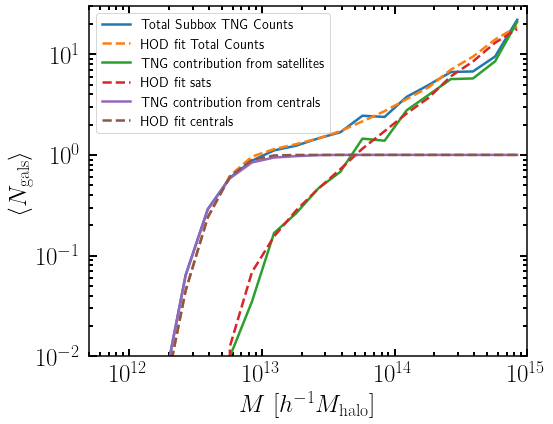

In [27]:
plt.figure(figsize=(8,6))

plt.plot(bin_cents, hod_true_tot,label='Total Subbox TNG Counts')
plt.plot(bin_cents, hod_fit,  linestyle = '--',label='HOD fit Total Counts')

plt.plot(bin_cents, hod_true_sat, label='TNG contribution from satellites')
plt.plot(bin_cents, hod_fit_sat, linestyle = '--',label='HOD fit sats')

plt.plot(bin_cents, hod_true_cent, label='TNG contribution from centrals')
plt.plot(bin_cents, hod_fit_cent, linestyle = '--',label='HOD fit centrals')

plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\langle N_\mathrm{gals} \rangle$')
plt.xlabel(r'$M\ [h^{-1}M_\mathrm{halo}]$')
plt.xlim(5e11,1e15)
plt.ylim(0.01,30)
plt.legend(fontsize='x-small');

# Train the RF to estimate the HOD

In [75]:
#check hyperparams using imported function
RF_checktraintestreg_hyperparams(X_train, X_test, y_train, y_test, ntrials=5,test_array=False, skip=False)

*************************
FIND NUM TREES AND LEAF SAMPLES
*************************
num_trees: 50  min_leaf: 1
Training scores 0.9693663789017093 +- 0.0020397700342515202
Test scores 0.7739372514749544 +- 0.0010323215196666037
#########################
#########################
num_trees: 100  min_leaf: 1
Training scores 0.9685449840289604 +- 0.0017102658434490943
Test scores 0.7747131664183143 +- 0.0025565238939473964
#########################
#########################
num_trees: 50  min_leaf: 5
Training scores 0.8625109254476998 +- 0.0003699039189860219
Test scores 0.7629941221500356 +- 0.00418456558621557
#########################
#########################
num_trees: 100  min_leaf: 5
Training scores 0.864295860056641 +- 0.0007797465694312477
Test scores 0.7652253262248188 +- 0.0029986076844579256
#########################
#########################
num_trees: 50  min_leaf: 10
Training scores 0.8186322281099265 +- 0.0007382878779923437
Test scores 0.7619847138005678 +- 0.0016348995862

In [76]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, n_jobs=-1)

In [77]:
start= time.time()

model.fit(X_train, y_train)

print('Time (s):', "{:.4f}".format((time.time()-start)))

Time (s): 7.3714


In [78]:
ypred=model.predict(X_test)

In [79]:
np.save('RF_data/mass_envth_shear_RFreg_galcounts', ypred)

In [80]:
ypred = np.load('RF_data/mass_envth_shear_RFreg_galcounts.npy')

### plot prediction results

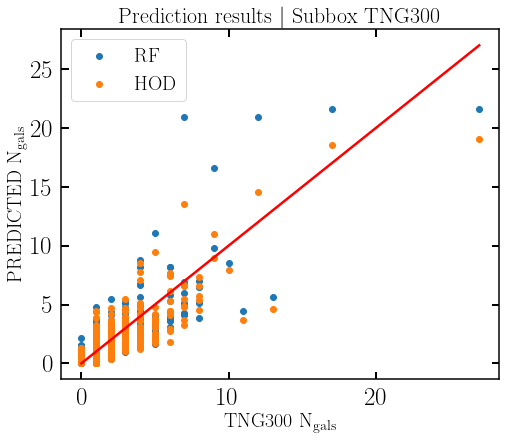

In [81]:
x = np.linspace(np.min(y_test),np.max(y_test), 100)
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_test,ypred, label = '$\mathrm{RF}$')
ax.scatter(y_test,fit_tot_counts, label = '$\mathrm{HOD}$')
ax.plot(x, x, linestyle='-', c='r')
ax.set_xlabel(r'$\rm{TNG300}\  N_{\rm gals} $', fontsize = 20)
ax.set_ylabel(r'$\rm{PREDICTED}\  N_{\rm gals} $', fontsize = 20)
ax.set_title(r'$\rm{Prediction\ results\ |\ Subbox\ TNG300}$')
plt.legend();
#plt.savefig('plots/title.pdf', bbox_inches='tight', dpi=150)

## Compare to prediction data from other models

Once you have trained several different models, you can load and compare the results. The following is an example.

In [82]:
#load results from other models
RF_mass                              = np.load('RF_data/mass_RFreg_galcounts.npy')
RF_mass_env_gs                       = np.load('RF_data/mass_env_gs_RFreg_galcounts.npy')
RF_mass_envann                       = np.load('RF_data/mass_envann_RFreg_galcounts.npy')
RF_mass_envth                        = np.load('RF_data/mass_envth_RFreg_galcounts.npy')

RF_mass_envth_shear                 = np.load('RF_data/mass_envth_shear_RFreg_galcounts.npy')
RF_mass_envth_shear1Mpc             = np.load('RF_data/mass_env_sh1Mpc_RFreg_galcounts.npy')

RF_mass_envth_shear_spin            = np.load('RF_data/mass_envth_shear_spin_RFreg_galcounts.npy')
RF_mass_envth_shear_spin_vmax       = np.load('RF_data/mass_envth_shear_spin_vmax_RFreg_galcounts.npy')
RF_mass_envth_shear_spin_vmax_vdisp = np.load('RF_data/mass_envth_shear_spin_vmax_vdisp_RFreg_galcounts.npy')

RF_mass_conc                 = np.load('RF_data/mass_conc_RFreg_galcounts.npy')

In [83]:
RF_mass_envth1Mpc_shear = np.load('RF_data/mass_env1Mpc_sh_RFreg_galcounts.npy')
RF_mass_envth2Mpc_shear = np.load('RF_data/mass_env2Mpc_sh_RFreg_galcounts.npy')
RF_mass_envth1Mpc_shear1Mpc = np.load('RF_data/mass_env1Mpc_sh1Mpc_RFreg_galcounts.npy')
RF_mass_envth2Mpc_shear1Mpc = np.load('RF_data/mass_env2Mpc_sh1Mpc_RFreg_galcounts.npy')

In [84]:
RF_mass_envth1Mpc = np.load('RF_data/mass_envth1Mpc_RFreg_galcounts.npy')
RF_mass_envth2Mpc = np.load('RF_data/mass_envth2Mpc_RFreg_galcounts.npy')
RF_mass_envth5Mpc = np.load('RF_data/mass_envth5Mpc_RFreg_galcounts.npy')


### Check how well we recovered the scatter

In [85]:
std = True

std_true_dm, bins             = get_hod(mass_test,y_test,mass_test, std)

std_mass                           = get_hod(mass_test, RF_mass, mass_test, std)[0]
std_mass_env                       = get_hod(mass_test, RF_mass_envth, mass_test, std)[0]
std_mass_env_shear                 = get_hod(mass_test, RF_mass_envth_shear, mass_test, std)[0]
std_mass_env_shear1Mpc             = get_hod(mass_test, RF_mass_envth_shear1Mpc, mass_test, std)[0]

std_mass_env_shear_spin            = get_hod(mass_test, RF_mass_envth_shear_spin, mass_test, std)[0]
std_mass_env_shear_spin_vmax       = get_hod(mass_test, RF_mass_envth_shear_spin_vmax,\
                                             mass_test, std)[0]
std_mass_env_shear_spin_vmax_vdisp = get_hod(mass_test, RF_mass_envth_shear_spin_vmax_vdisp,\
                                             mass_test, std)[0]

In [86]:
std = False

hod_true_dm                        = get_hod(mass_test,y_test,mass_test, std)[0]

hod_mass                           = get_hod(mass_test, RF_mass, mass_test, std)[0]
 
hod_mass_env                       = get_hod(mass_test, RF_mass_envth, mass_test, std)[0]
hod_mass_env_shear                 = get_hod(mass_test, RF_mass_envth_shear, mass_test, std)[0]

hod_mass_env_shear_spin            = get_hod(mass_test, RF_mass_envth_shear_spin, mass_test, std)[0]
hod_mass_env_shear_spin_vmax       = get_hod(mass_test, RF_mass_envth_shear_spin_vmax,\
                                             mass_test, std)[0]
hod_mass_env_shear_spin_vmax_vdisp = get_hod(mass_test, RF_mass_envth_shear_spin_vmax_vdisp,\
                                             mass_test, std)[0]

/Users/anamariadelgado/Desktop/Delgado_TNG_collab/get_hod_corrfunc.py:54: RuntimeWarning: invalid value encountered in true_divide
  hist_hod = hist_weighted/hist_norm # to get average number of halo living in each bin


<ipython-input-92-8fb0bc95f962>:3: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bins[0:26], (std_true_dm/std_true_dm)[0:26], color='C1', label='$\mathrm{Subbox\ TNG300-matched}$')
<ipython-input-92-8fb0bc95f962>:4: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(bins[0:26], (std_mass_env_shear_spin_vmax_vdisp/std_true_dm)[0:26], color='C5',linestyle='dashed', label='$\mathrm{vdisp,\ vmax,\ spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$');
<ipython-input-92-8fb0bc95f962>:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(bins[0:26], (std_mass_env_shear_spin_vmax/std_true_dm)[0:26], color='C4',linestyle='dashed', label='$\mathrm{vmax,\ spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$');
<ipython-input-92-8fb0bc95f962>:6: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(bins[0:26], (std_mass_env_shear_spin/std_true_dm)[0:26], linestyle='dashed', label='$\mathrm{spin},\ q^2,\ \delta_\mathrm{env},\ M_

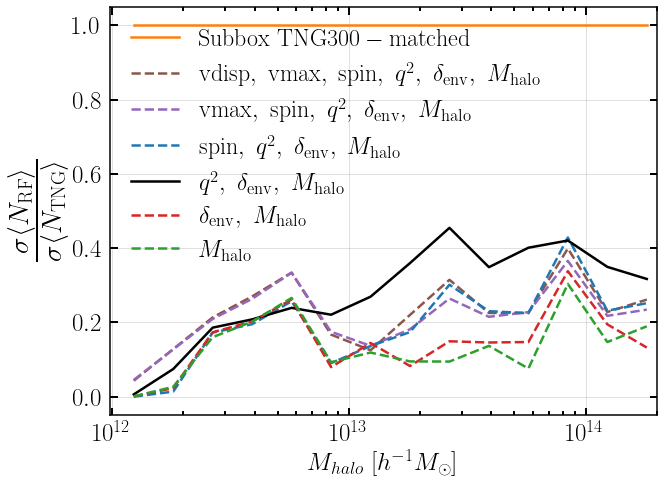

In [92]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(bins[0:26], (std_true_dm/std_true_dm)[0:26], color='C1', label='$\mathrm{Subbox\ TNG300-matched}$')
ax.plot(bins[0:26], (std_mass_env_shear_spin_vmax_vdisp/std_true_dm)[0:26], color='C5',linestyle='dashed', label='$\mathrm{vdisp,\ vmax,\ spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$');
ax.plot(bins[0:26], (std_mass_env_shear_spin_vmax/std_true_dm)[0:26], color='C4',linestyle='dashed', label='$\mathrm{vmax,\ spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$');
ax.plot(bins[0:26], (std_mass_env_shear_spin/std_true_dm)[0:26], linestyle='dashed', label='$\mathrm{spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$');
ax.plot(bins[0:26], (std_mass_env_shear/std_true_dm)[0:26], color='black', label='$q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$');
ax.plot(bins[0:26], (std_mass_env/std_true_dm)[0:26], linestyle='dashed',color='C3', label='$\delta_\mathrm{env},\ M_\mathrm{halo}$');

ax.plot(bins[0:26], (std_mass/std_true_dm)[0:26], color='C2', linestyle='dashed', label='$M_\mathrm{halo}$');
#ax.plot(bins[0:26], (std_mass_env_shear1Mpc/std_true_dm)[0:26], color='black',linestyle='dashed', label='shear $\mathrm{1.3\ Mpc}$, env, mass');

ax.set_xlim(10**11.99,2e14)

ax.set_xscale('log')
ax.set_ylabel(r'$\frac{\sigma\langle N_{\mathrm{RF}} \rangle}{\sigma\langle  N_{\mathrm{TNG}} \rangle}$', fontsize=40)
ax.set_xlabel(r'$M_{halo}\ [ h^{-1}M_{\odot}]$')

plt.legend(loc='upper left',fontsize='large',frameon=False)
plt.grid(which='major', c='grey', alpha=0.3);
#plt.savefig('plots/title.pdf', dpi=150)

# Correlation Function 

We use the two-point correlation function as a measure of performance

In [93]:
def xi_Corrfunc(positions, weights, boxLen, return_bins):
    '''
    gives positions, weights and size of box to pass to Corrfunc funtion
    '''
    bins = np.logspace(-1.,1.,21)
    bin_cents = 0.5*(bins[1:]+bins[:-1])
    
    xi = Corrfunc.theory.xi(X=positions[:,0],Y=positions[:,1],Z=positions[:,2],boxsize=boxLen,\
                             weights=weights,weight_type='pair_product',nthreads=16,binfile=bins)['xi']
    if return_bins==True:
        return xi, bin_cents
    
    elif return_bins==False:
        return xi

In [94]:
def non_periodic_corrfunc(positions, weights, boxsize, return_bins, periodic=False):
    '''
    Because we split up our volume into training and testing sub-volumes,
    our sub-volumes are non-periodic, we therefor need a correlation function for 
    non-periodic volume
    '''
    np.random.seed(0)
    
    bins = np.logspace(-1.,1.,21)
    bin_cents = 0.5*(bins[1:]+bins[:-1])
    
    X=positions[:,0]
    Y=positions[:,1]
    Z=positions[:,2]
    mean_w  = np.mean(weights)
    
    N = len(positions)
    nthreads = 16
    
    dtype = np.float64
    
    # Generate randoms on the box
    rand_N = 15*N
    rand_X = np.random.uniform(0, boxsize, rand_N).astype(dtype)
    rand_Y = np.random.uniform(0, boxsize, rand_N).astype(dtype)
    rand_Z = np.random.uniform(0, boxsize, rand_N).astype(dtype)
    rand_W = np.ones(rand_N, dtype=dtype)*mean_w
    
    # Auto pair counts in DD
    autocorr = 1
    DD_counts = DD(autocorr, nthreads, bins, X, Y, Z, weights1=weights, weight_type='pair_product', periodic=periodic, boxsize=boxsize)
    
    # Cross pair counts in DR
    autocorr = 0
    DR_counts = DD(autocorr, nthreads, bins, X, Y, Z, weights1=weights, weight_type='pair_product', X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic=periodic, weights2=rand_W)
    
    # Auto pairs counts in RR
    autocorr = 1
    RR_counts = DD(autocorr, nthreads, bins, rand_X, rand_Y, rand_Z, weights1=rand_W, weight_type='pair_product', periodic=periodic, boxsize=boxsize)
    
    # All the pair counts are done, get the correlation function
    DD_n = DD_counts['npairs']*DD_counts['weightavg']/N**2
    RR_n = RR_counts['npairs']*RR_counts['weightavg']/rand_N**2
    DR_n = DR_counts['npairs']*DR_counts['weightavg']/(rand_N*N)
    RD_n = DR_n
    cf = (DD_n-RD_n-DR_n+RR_n)/RR_n
    if return_bins == True:
        return cf, bin_cents
    elif return_bins == False:
        return cf

In [95]:
def make_non_p_xi_arrays(positions, weights, boxLen, return_bins):
    
    mask = weights>0
    
    xyz  = positions[mask].astype(np.float64)
    w    = weights[mask].astype(np.float64)
    
    if return_bins==True:
        xi, bin_cents = non_periodic_corrfunc(xyz, w, boxLen, return_bins, periodic=False)
        return xi, bin_cents
    
    elif return_bins==False:
        xi = non_periodic_corrfunc(xyz, w, boxLen, return_bins, periodic=False)
        return xi

calculate the 2-point correlation functions

In [96]:
#Subboxes True
xi_non_p_sub_dm, bin_cents = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                  count_dm[mass_mask][maskBox], boxLen, True)

In [97]:
#RF results
xi_non_p_rf_mass                              = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                                     RF_mass, boxLen, False)
xi_non_p_rf_mass_envann                       = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                                     RF_mass_envann, boxLen, False)
xi_non_p_rf_mass_envth                       = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                                     RF_mass_envth, boxLen, False)
xi_non_p_rf_mass_envth_shear                 = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                                     RF_mass_envth_shear, boxLen, False)
xi_non_p_rf_mass_envth_shear1Mpc             = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                                     RF_mass_envth_shear1Mpc, boxLen, False)


In [98]:
xi_non_p_rf_mass_envth_shear_spin            = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                                     RF_mass_envth_shear_spin, boxLen, False)
xi_non_p_rf_mass_envth_shear_spin_vmax       = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                               RF_mass_envth_shear_spin_vmax, boxLen, False)
xi_non_p_rf_mass_envth_shear_spin_vmax_vdisp = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                               RF_mass_envth_shear_spin_vmax_vdisp, boxLen, False)

In [99]:
xi_non_p_rf_mass_env_gs  = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                                     RF_mass_env_gs, boxLen, False)
xi_non_p_rf_mass_conc    = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                                     RF_mass_conc, boxLen, False)

In [100]:
xi_non_p_rf_mass_envth1Mpc_shear = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                        RF_mass_envth1Mpc_shear, boxLen, False)

xi_non_p_rf_mass_envth2Mpc_shear = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                        RF_mass_envth2Mpc_shear, boxLen, False)
xi_non_p_rf_mass_envth1Mpc_shear1Mpc = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                        RF_mass_envth1Mpc_shear1Mpc, boxLen, False)
xi_non_p_rf_mass_envth2Mpc_shear1Mpc = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox], \
                                                        RF_mass_envth2Mpc_shear1Mpc, boxLen, False)

In [101]:
xi_non_p_rf_mass_envth1Mpc  = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                    RF_mass_envth1Mpc, boxLen, False)

xi_non_p_rf_mass_envth2Mpc  = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                    RF_mass_envth2Mpc, boxLen, False)

xi_non_p_rf_mass_envth5Mpc  = make_non_p_xi_arrays(GroupPos_dm[mass_mask][maskBox],\
                                                    RF_mass_envth5Mpc, boxLen, False)

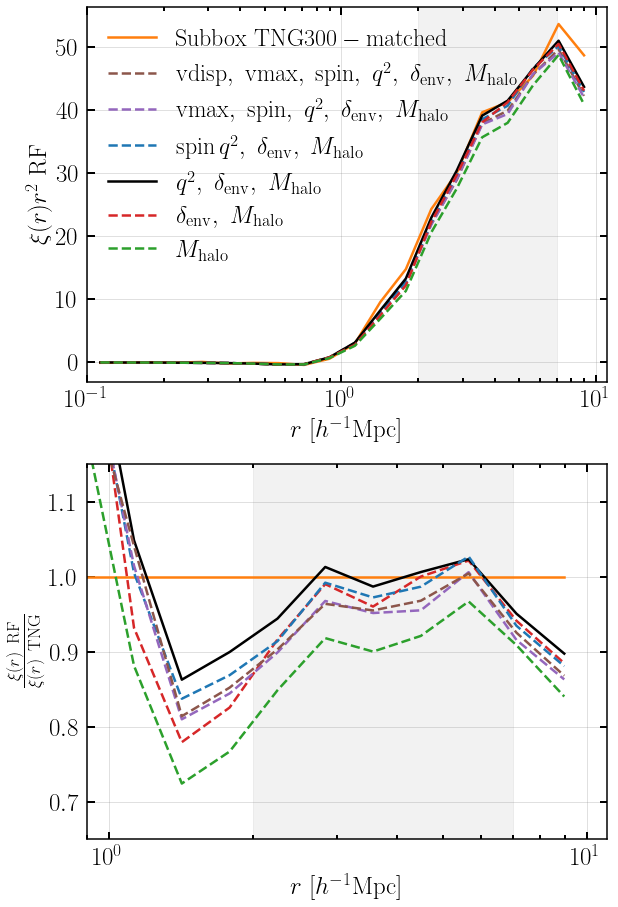

In [103]:
fig, ax = plt.subplots(2,1,figsize=(9,13))
ax[0].plot(bin_cents,xi_non_p_sub_dm*bin_cents**2, color='C1',label='$\mathrm{Subbox\ TNG300-matched}$')
ax[0].plot(bin_cents,(xi_non_p_rf_mass_envth_shear_spin_vmax_vdisp*bin_cents**2),color='C5', linestyle='dashed', label='$\mathrm{vdisp,\ vmax,\ spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$')
ax[0].plot(bin_cents,(xi_non_p_rf_mass_envth_shear_spin_vmax*bin_cents**2), color='C4', linestyle='dashed', label='$\mathrm{vmax,\ spin},\ q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$')
ax[0].plot(bin_cents,(xi_non_p_rf_mass_envth_shear_spin*bin_cents**2), linestyle='dashed', label='$\mathrm{spin}\, q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$')
ax[0].plot(bin_cents,(xi_non_p_rf_mass_envth_shear*bin_cents**2), color='black', label='$q^2,\ \delta_\mathrm{env},\ M_\mathrm{halo}$')
ax[0].plot(bin_cents,(xi_non_p_rf_mass_envth*bin_cents**2),color='C3', linestyle='dashed', label='$\delta_\mathrm{env},\ M_\mathrm{halo}$')
ax[0].plot(bin_cents,(xi_non_p_rf_mass*bin_cents**2), color='C2',linestyle='dashed', label='$M_\mathrm{halo}$')
#ax[0].plot(bin_cents,(xi_non_p_rf_mass_envth_shear1Mpc*bin_cents**2), color='C6',linestyle='dashed', label='$q^2\ \mathrm{1.3\ Mpc},\ \delta_\mathrm{env},\ M_\mathrm{halo}$')



ax[1].plot(bin_cents,(xi_non_p_sub_dm*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color='C1')
ax[1].plot(bin_cents,(xi_non_p_rf_mass*bin_cents**2/(xi_non_p_sub_dm*bin_cents**2)), color='C2',linestyle='dashed')
ax[1].plot(bin_cents,(xi_non_p_rf_mass_envth*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2),color='C3', linestyle='dashed')
ax[1].plot(bin_cents,(xi_non_p_rf_mass_envth_shear*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color='black')
#ax[1].plot(bin_cents,(xi_non_p_rf_mass_envth_shear1Mpc*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color='C6', linestyle='dashed')

ax[1].plot(bin_cents,(xi_non_p_rf_mass_envth_shear_spin*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), linestyle='dashed')
ax[1].plot(bin_cents,(xi_non_p_rf_mass_envth_shear_spin_vmax*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color='C4', linestyle='dashed')
ax[1].plot(bin_cents,(xi_non_p_rf_mass_envth_shear_spin_vmax_vdisp*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2),color='C5', linestyle='dashed')

for i in range(2):
    ax[i].set_xlabel(r'$r \ [h^{-1}{\rm Mpc}]$')
    ax[i].set_xscale('log')    
    ax[i].grid(which='major', c='grey', alpha=0.3)
    ax[i].axvspan(2, 7, alpha=0.1, color='grey')

ax[1].set_ylabel(r'$\frac{\xi(r)\ \mathrm{RF}} {\xi(r)\  \mathrm{TNG}}$')
ax[0].set_ylabel(r'$\xi(r)r^2\ \mathrm{RF}$')

ax[0].legend(fontsize = 'large',loc = 'upper left', ncol=1, frameon=False)# framealpha=0.3)
ax[1].set_xlim([0.9,11])
ax[1].set_ylim([0.65,1.15])
ax[0].set_xlim([0.1,11])
plt.tight_layout()

#plt.savefig('plots/title.pdf', bbox_inches='tight', dpi=150);

In [110]:
path = 'AB_ML_plotdata/FigB1_'
np.save(path+'bin_cents', bin_cents)
np.save(path+'xi_RF_TNG300_true', xi_non_p_sub_dm)
np.save(path+'xi_RF_mass_envth', xi_non_p_rf_mass_envth)
np.save(path+'xi_RF_mass_envth2Mpc', xi_non_p_rf_mass_envth2Mpc)
np.save(path+'xi_RF_mass_envth1Mpc', xi_non_p_rf_mass_envth1Mpc)

np.save(path+'xi_RF_fiducial', xi_non_p_rf_mass_envth_shear)
np.save(path+'xi_RF_envth2Mpc_shear', xi_non_p_rf_mass_envth2Mpc_shear)
np.save(path+'xi_RF_mass_envth1Mpc_shear', xi_non_p_rf_mass_envth1Mpc_shear)

np.save(path+'xi_RF_mass_envth_shear1Mpc', xi_non_p_rf_mass_envth_shear1Mpc)
np.save(path+'xi_RF_mass_envth2Mpc_shear1Mpc', xi_non_p_rf_mass_envth2Mpc_shear1Mpc)
np.save(path+'xi_RF_mass_envth1Mpc_shear1Mpc', xi_non_p_rf_mass_envth1Mpc_shear1Mpc)

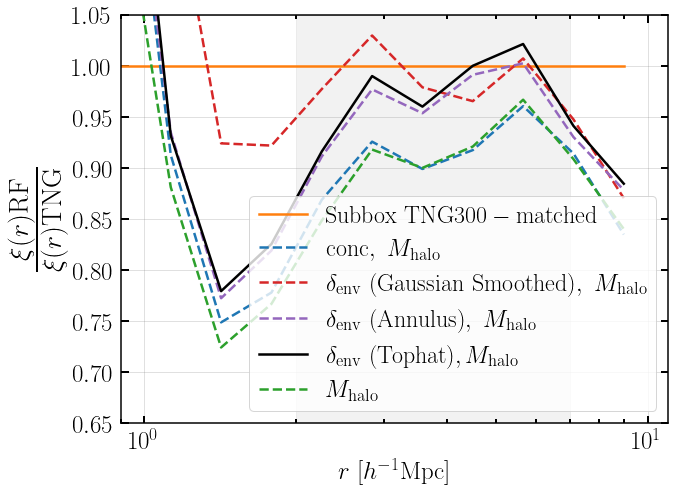

In [111]:
plt.figure(figsize=(10,7))
plt.plot(bin_cents,(xi_non_p_sub_dm*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color='C1', label='$\mathrm{Subbox\ TNG300-matched}$')
plt.plot(bin_cents,(xi_non_p_rf_mass_conc*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), linestyle='dashed', label='$\mathrm{conc},\ M_\mathrm{halo}$')
plt.plot(bin_cents,(xi_non_p_rf_mass_env_gs*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2),color = 'C3', linestyle='dashed', label='$\delta_\mathrm{env}\ \mathrm{(Gaussian\ Smoothed)},\ M_\mathrm{halo}$')
plt.plot(bin_cents,(xi_non_p_rf_mass_envann*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color = 'C4', linestyle='dashed', label='$\delta_\mathrm{env}\ \mathrm{(Annulus)},\ M_\mathrm{halo}$')
plt.plot(bin_cents,(xi_non_p_rf_mass_envth*bin_cents**2)/(xi_non_p_sub_dm*bin_cents**2), color = 'black', label='$\delta_\mathrm{env}\ \mathrm{(Tophat)}, M_\mathrm{halo}$')
plt.plot(bin_cents,(xi_non_p_rf_mass*bin_cents**2/(xi_non_p_sub_dm*bin_cents**2)), color = 'C2', linestyle='dashed', label='$M_\mathrm{halo}$')

plt.xlabel(r'$r \ [h^{-1}{\rm Mpc}]$')
plt.ylabel(r'$\frac{\xi(r)  \mathrm{RF}} {\xi(r)  \mathrm{TNG}}$', fontsize=40)
plt.xscale('log')
plt.legend(fontsize = 'large', loc = 'lower right', ncol=1)
plt.xlim([0.9,11])
plt.ylim([0.65,1.05])
plt.grid(which='major', c='grey', alpha=0.3)
plt.axvspan(2, 7, alpha=0.1, color='grey')
#plt.savefig('plots/overleaf/RF_TNG300_2env_compare_corrfunc_singleplot_refupdate_textsize.pdf', bbox_inches='tight', dpi=150);